In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
%matplotlib inline

In [16]:
path_to_data = "./cropped_images/"
path_to_test_data = "G:\\Flickr\\skyspkrl\\test\\"

In [17]:
batch_size = 32
img_height = 256
img_width = 256

In [18]:
train_ds  = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_data, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), 
    subset="training",
    shuffle=True, seed=123, validation_split=0.2,
    interpolation='bilinear', follow_links=False
)

Found 274 files belonging to 5 classes.
Using 220 files for training.


In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 274 files belonging to 5 classes.
Using 54 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']


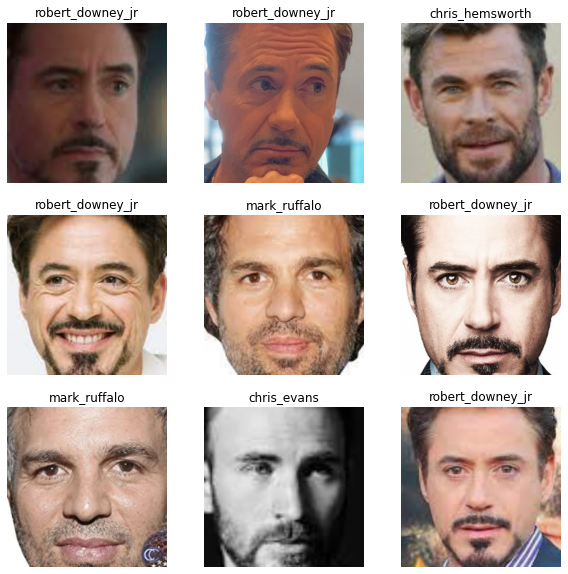

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [22]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9978631


In [26]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

7/7 [==============================] - 5s 789ms/step - loss: 2.2609 - accuracy: 0.2268 - val_loss: 1.6923 - val_accuracy: 0.2407


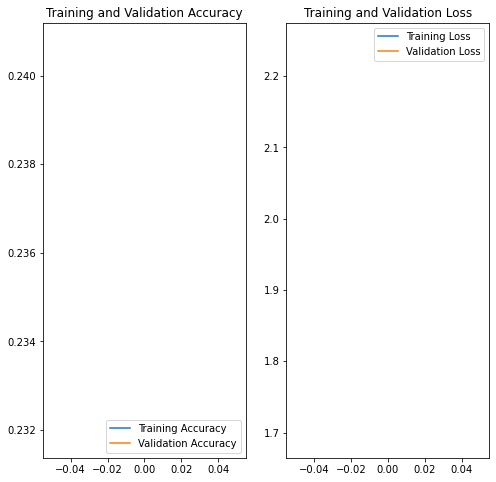

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

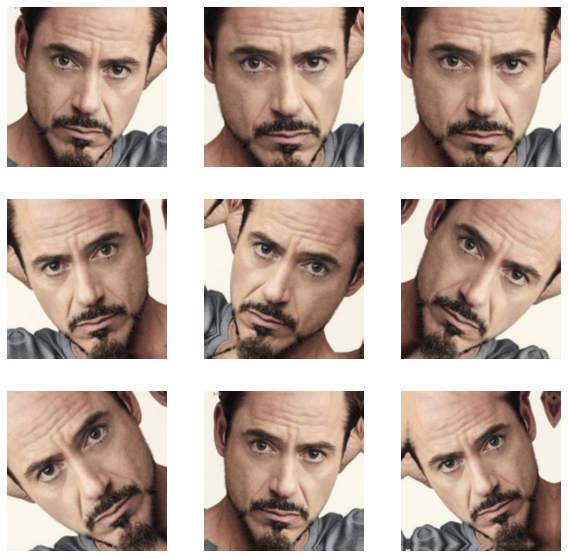

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [32]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 4
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4
7/7 [==============================] - 3s 321ms/step - loss: 2.3698 - accuracy: 0.1819 - val_loss: 1.6653 - val_accuracy: 0.2407
Epoch 2/4
7/7 [==============================] - 2s 288ms/step - loss: 1.5957 - accuracy: 0.2207 - val_loss: 1.6825 - val_accuracy: 0.1852
Epoch 3/4
7/7 [==============================] - 2s 287ms/step - loss: 1.6000 - accuracy: 0.2180 - val_loss: 1.6319 - val_accuracy: 0.2407
Epoch 4/4
7/7 [==============================] - 2s 287ms/step - loss: 1.5946 - accuracy: 0.2437 - val_loss: 1.6105 - val_accuracy: 0.2593


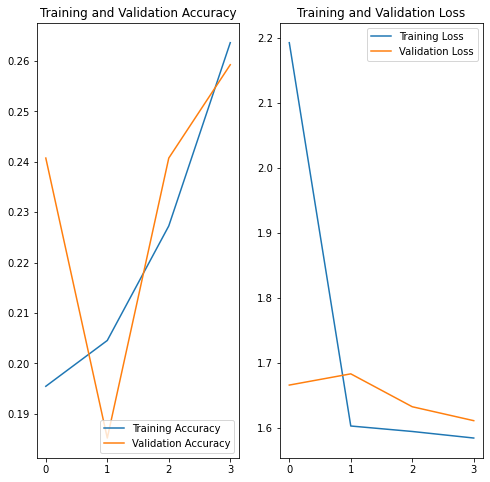

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


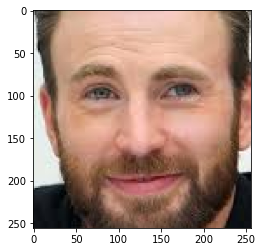

In [76]:
from keras.preprocessing import image
IMG_SIZE = 256
batch_holder = np.zeros((5, 256, 256, 3))
img_dir='./test/'
for i,img in enumerate(os.listdir(img_dir)):
    img = image.load_img(os.path.join(img_dir,img), target_size=(IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
#     batch_holder[i, :] = img
    
    
    


In [36]:
loaded_model=tf.keras.models.load_model('saved_model/my_model')
result=loaded_model.predict_classes(batch_holder)

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [37]:
result

array([2, 2, 2, 2, 2], dtype=int64)

In [38]:
loaded_model.predict_proba

<bound method Sequential.predict_proba of <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000262160496D0>>

In [39]:
class_names

['chris_evans',
 'chris_hemsworth',
 'mark_ruffalo',
 'robert_downey_jr',
 'scarlett_johansson']

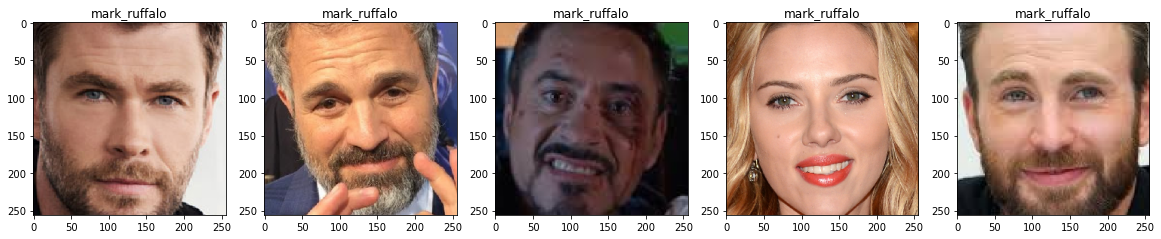

In [40]:
fig = plt.figure(figsize=(20, 20))

for i,img in enumerate(batch_holder):
    fig.add_subplot(4,5, i+1)
    plt.title(class_names[result[i]])
    plt.imshow(img/256.)
  
plt.show()

In [41]:
class_dict = {}
for i in range(len(class_names)):
    class_dict[i] = class_names[i]
class_dict

{0: 'chris_evans',
 1: 'chris_hemsworth',
 2: 'mark_ruffalo',
 3: 'robert_downey_jr',
 4: 'scarlett_johansson'}

In [42]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [43]:
for results in result:
    print(results)

2
2
2
2
2


In [45]:
from keras.preprocessing import image
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
import joblib
import base64
import json
import numpy as np

In [46]:
__class_number_to_name = []
__model = None

In [47]:
def load_saved_artifacts():
    print("loading saved artifacts...start")
    global __class_name_to_number
    global __class_number_to_name
    global __model

    with open("./artifact/class_dictionary.json", "r") as f:
        __class_number_to_name = json.load(f)

    if __model is None:
        __model = tf.keras.models.load_model('./artifact/saved_model/my_model')
    print("loading saved artifacts...done")


In [48]:
def get_cv2_image_from_base64_string(b64str):
    '''
    credit: https://stackoverflow.com/questions/33754935/read-a-base-64-encoded-image-from-memory-using-opencv-python-library
    :param uri:
    :return:
    '''
    encoded_data = b64str.split(',')[1]
    nparr = np.frombuffer(base64.b64decode(encoded_data), np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img


In [118]:
def get_cropped_image_if_2_eyes(image_base64_data, image_path):
    face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_eye.xml')
    cropped_faces = []
    if image_path:
        img = cv2.imread(image_path)
    else:
        img = get_cv2_image_from_base64_string(image_base64_data)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = img[y:y + h, x:x + w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            
            cropped_faces.append(roi_color)
    return cropped_faces


In [142]:
def classify_image(image_base64_data, file_path=None):
    imgs = get_cropped_image_if_2_eyes(image_base64_data, file_path)
    IMG_SIZE = 256
#     img = image.load_img(file_path, target_size=(IMG_SIZE,IMG_SIZE))
    for img in imgs:
    
        image = cv2.resize(img, (256, 256))
        batch_holder = np.zeros((1, 256, 256, 3))
        batch_holder[0, :] = image
        re=__model.predict_classes(batch_holder)
        print(re)

    
    result = [{
            'class': __class_number_to_name[str(re[0])],
            'class_probability': np.around(__model.predict_proba(batch_holder) * 100, 2).tolist()[0],
            'class_dictionary': __class_number_to_name
            }]
    return result


In [144]:
load_saved_artifacts()
print(classify_image(None, "./test/thor.png"))

loading saved artifacts...start
loading saved artifacts...done
[1]
[{'class': 'chris_hemsworth', 'class_probability': [168.17999267578125, 280.5299987792969, 12.670000076293945, 130.35000610351562, -698.4299926757812], 'class_dictionary': {'0': 'chris_evans', '1': 'chris_hemsworth', '2': 'mark_ruffalo', '3': 'robert_downey_jr', '4': 'scarlett_johansson'}}]
